In [1]:
# import packages & variables
import argparse
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoModelForSequenceClassification
import json
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "5"

# Parameters
model_name = 'meta-llama/Meta-Llama-3.1-8B'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra.non_infringement.json'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra.infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_last_layer_test.pth'


/home/guangwei/miniconda3/envs/zdh/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define CustumMLP for internal states train
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomMLP, self).__init__()
        self.down = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Linear(input_dim, hidden_dim)
        self.up = nn.Linear(hidden_dim, 1)
        self.activation = nn.SiLU()

    def forward(self, x):
        down_output = self.down(x)
        gate_output = self.gate(x)
        gated_output = down_output * self.activation(gate_output)
        return self.up(gated_output)

In [3]:
# Extract hidden states for both input and reference texts
def extract_char(inputs, references, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    extract_chars = []

    # Iterate through the batches of inputs and references
    for i in tqdm(range(0, len(inputs), batch_size), desc="Processing data batches"):
        # Prepare batch for input texts
        batch_inputs = inputs[i:i + batch_size]
        batch_references = references[i:i + batch_size]
        
        # Tokenize both input and reference texts
        inputs_combined = [f"{input_text} [SEP] {reference_text}" for input_text, reference_text in zip(batch_inputs, batch_references)]
        encoded_inputs = tokenizer(inputs_combined, return_tensors="pt", padding=True, truncation=True).to(device)
        
        with torch.no_grad():
            # Get hidden states from the model
            outputs = model(**encoded_inputs)
        
        # Average the hidden states from the last layer for the combined input-reference representation
        combined_hidden_states = outputs.hidden_states[-1].mean(dim=1)  # shape: (batch_size, hidden_size)
        
        # Move to CPU and convert to numpy
        extract_chars.append(combined_hidden_states.cpu().numpy())
    
    return np.vstack(extract_chars)


In [4]:
# Function to extract hidden states from the outputs of extract_char
def extract_hidden_states(extract_chars, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    
    hidden_states = []
    
    # Process the extract_chars as if they were new texts
    for i in tqdm(range(0, len(extract_chars), batch_size), desc="Processing hidden states"):
        batch_extract_chars = extract_chars[i:i + batch_size]

        # Since batch_extract_chars are already features, we can process them directly.
        # Here, we will simply append them as hidden states since they are already in the form needed.
        hidden_states.append(batch_extract_chars)

    return np.vstack(hidden_states)

In [5]:
# load data for infringement & non infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    non_infringement_references = [entry['reference'] for entry in non_infringement_json_data]
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    infringement_references = [entry['reference'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement

In [6]:
# Train for best model
def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=500, lr=0.001, checkpoint_path=checkpoint_file):
    custom_mlp = CustomMLP(input_dim, hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    best_accuracy = -float('inf')
    best_model_state = None
    best_epoch = 0
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().numpy()
            
            accuracy = accuracy_score(y_test, y_pred)
            print(f"Test Accuracy at Epoch {epoch + 1}: {accuracy * 100:.2f}%")
            
            report = classification_report(y_test, y_pred, target_names=["infringement", "non_infringement"])
            print(f"Classification Report at Epoch {epoch + 1}:\n{report}")

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model_state = custom_mlp.state_dict()
                best_epoch = epoch + 1
                torch.save(best_model_state, checkpoint_path)
                print(f"New best model saved with accuracy {best_accuracy * 100:.2f}% at epoch {best_epoch}")
                print(f"Best Classification Report at Epoch {best_epoch}:\n{report}")

    custom_mlp.load_state_dict(torch.load(checkpoint_path))

    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
    
    return custom_mlp, losses, best_accuracy

In [7]:
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer.pad_token = tokenizer.eos_token
bert_tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')
bert_model = AutoModel.from_pretrained('google-bert/bert-base-uncased')
bert_tokenizer.pad_token = tokenizer.eos_token

non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement = load_data(
    non_infringement_file, infringement_file
)

y_non_infringement = np.array(y_non_infringement)
y_infringement = np.array(y_infringement)


/home/guangwei/miniconda3/envs/zdh/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.40it/s]


In [8]:
# print("Extracting hidden states for non_infringement texts...")
# X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)
# print("Extracting reference embeddings for non_infringement texts...")
# reference_embeddings_non_infringement = extract_reference_embeddings(non_infringement_references, bert_model, bert_tokenizer)
# print("X_non_infringement:",X_non_infringement.shape)
# print("reference_embeddings_non_infringement:",reference_embeddings_non_infringement.shape)
# X_non_infringement_combined = np.hstack([X_non_infringement, reference_embeddings_non_infringement])

# print("Extracting hidden states for infringement texts...")
# X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)
# print("Extracting reference embeddings for infringement texts...")
# reference_embeddings_infringement = extract_reference_embeddings(infringement_references, bert_model, bert_tokenizer)
# X_infringement_combined = np.hstack([X_infringement, reference_embeddings_infringement])

# print("Extracting characteristics for non_infringement texts/references")
# X_non_infringement_char = extract_char(non_infringement_outputs, non_infringement_references, bert_model, bert_tokenizer)
# print("Extracting hidden states for X_non_infringement_char")
# X_non_infringement_combined = extract_hidden_states(X_non_infringement_char, model, tokenizer)

# print("Extracting characteristics for infringement texts/references")
# X_infringement_char = extract_char(infringement_outputs, infringement_references, bert_model, bert_tokenizer)
# print("Extracting hidden states for X_non_infringement_char")
# X_infringement_combined = extract_hidden_states(X_infringement_char, model, tokenizer)

print("Extracting characteristics for non_infringement texts/references")
X_non_infringement_combined = extract_char(non_infringement_outputs, non_infringement_references, model, tokenizer)

print("Extracting characteristics for infringement texts/references")
X_infringement_combined = extract_char(infringement_outputs, infringement_references, model, tokenizer)


Extracting characteristics for non_infringement texts/references


Processing data batches: 100%|██████████| 373/373 [03:35<00:00,  1.73it/s]


Extracting characteristics for infringement texts/references


Processing data batches: 100%|██████████| 354/354 [03:22<00:00,  1.75it/s]


In [9]:
split_index_non_infringement = int(0.8 * len(X_non_infringement_combined))
X_non_infringement_train = X_non_infringement_combined[:split_index_non_infringement]
X_non_infringement_test = X_non_infringement_combined[split_index_non_infringement:]
y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

split_index_infringement = int(0.8 * len(X_infringement_combined))
X_infringement_train = X_infringement_combined[:split_index_infringement]
X_infringement_test = X_infringement_combined[split_index_infringement:]
y_infringement_train = y_infringement[:split_index_infringement]
y_infringement_test = y_infringement[split_index_infringement:]

X_train = np.vstack((X_non_infringement_train, X_infringement_train))
X_test = np.vstack((X_non_infringement_test, X_infringement_test))
y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

print("Data successfully split into training and test sets.")

Data successfully split into training and test sets.


Training MLP model with input_dim=4096 and hidden_dim=256


Training Epochs:   3%|▎         | 14/500 [00:00<00:20, 23.93it/s]

Epoch 10/500, Loss: 0.5887
Test Accuracy at Epoch 10: 63.51%
Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.78      0.35      0.49       283
non_infringement       0.60      0.90      0.72       298

        accuracy                           0.64       581
       macro avg       0.69      0.63      0.60       581
    weighted avg       0.68      0.64      0.60       581

New best model saved with accuracy 63.51% at epoch 10
Best Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.78      0.35      0.49       283
non_infringement       0.60      0.90      0.72       298

        accuracy                           0.64       581
       macro avg       0.69      0.63      0.60       581
    weighted avg       0.68      0.64      0.60       581



Training Epochs:   5%|▍         | 24/500 [00:01<00:17, 27.67it/s]

Epoch 20/500, Loss: 0.5052
Test Accuracy at Epoch 20: 68.16%
Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.73      0.55      0.63       283
non_infringement       0.65      0.81      0.72       298

        accuracy                           0.68       581
       macro avg       0.69      0.68      0.67       581
    weighted avg       0.69      0.68      0.68       581

New best model saved with accuracy 68.16% at epoch 20
Best Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.73      0.55      0.63       283
non_infringement       0.65      0.81      0.72       298

        accuracy                           0.68       581
       macro avg       0.69      0.68      0.67       581
    weighted avg       0.69      0.68      0.68       581



Training Epochs:   7%|▋         | 35/500 [00:01<00:16, 28.52it/s]

Epoch 30/500, Loss: 0.4177
Test Accuracy at Epoch 30: 70.22%
Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.72      0.64      0.68       283
non_infringement       0.69      0.77      0.72       298

        accuracy                           0.70       581
       macro avg       0.70      0.70      0.70       581
    weighted avg       0.70      0.70      0.70       581

New best model saved with accuracy 70.22% at epoch 30
Best Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.72      0.64      0.68       283
non_infringement       0.69      0.77      0.72       298

        accuracy                           0.70       581
       macro avg       0.70      0.70      0.70       581
    weighted avg       0.70      0.70      0.70       581



Training Epochs:   9%|▉         | 45/500 [00:01<00:15, 28.61it/s]

Epoch 40/500, Loss: 0.3610
Test Accuracy at Epoch 40: 71.08%
Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.81      0.53      0.64       283
non_infringement       0.66      0.88      0.76       298

        accuracy                           0.71       581
       macro avg       0.74      0.71      0.70       581
    weighted avg       0.73      0.71      0.70       581

New best model saved with accuracy 71.08% at epoch 40
Best Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.81      0.53      0.64       283
non_infringement       0.66      0.88      0.76       298

        accuracy                           0.71       581
       macro avg       0.74      0.71      0.70       581
    weighted avg       0.73      0.71      0.70       581



Training Epochs:  11%|█         | 54/500 [00:02<00:14, 30.04it/s]

Epoch 50/500, Loss: 0.3019
Test Accuracy at Epoch 50: 70.22%
Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.76      0.56      0.65       283
non_infringement       0.67      0.84      0.74       298

        accuracy                           0.70       581
       macro avg       0.72      0.70      0.69       581
    weighted avg       0.71      0.70      0.70       581



Training Epochs:  12%|█▏        | 62/500 [00:02<00:13, 31.29it/s]

Epoch 60/500, Loss: 0.2609
Test Accuracy at Epoch 60: 68.67%
Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.83      0.45      0.58       283
non_infringement       0.64      0.91      0.75       298

        accuracy                           0.69       581
       macro avg       0.73      0.68      0.67       581
    weighted avg       0.73      0.69      0.67       581



Training Epochs:  14%|█▍        | 70/500 [00:02<00:15, 28.54it/s]

Epoch 70/500, Loss: 0.2489
Test Accuracy at Epoch 70: 72.29%
Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.83      0.54      0.66       283
non_infringement       0.67      0.89      0.77       298

        accuracy                           0.72       581
       macro avg       0.75      0.72      0.71       581
    weighted avg       0.75      0.72      0.71       581

New best model saved with accuracy 72.29% at epoch 70
Best Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.83      0.54      0.66       283
non_infringement       0.67      0.89      0.77       298

        accuracy                           0.72       581
       macro avg       0.75      0.72      0.71       581
    weighted avg       0.75      0.72      0.71       581



Training Epochs:  16%|█▋        | 82/500 [00:03<00:14, 29.61it/s]

Epoch 80/500, Loss: 0.2299
Test Accuracy at Epoch 80: 69.88%
Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.83      0.48      0.61       283
non_infringement       0.65      0.90      0.75       298

        accuracy                           0.70       581
       macro avg       0.74      0.69      0.68       581
    weighted avg       0.73      0.70      0.68       581



Training Epochs:  19%|█▉        | 94/500 [00:03<00:12, 31.74it/s]

Epoch 90/500, Loss: 0.2167
Test Accuracy at Epoch 90: 70.22%
Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.80      0.52      0.63       283
non_infringement       0.66      0.88      0.75       298

        accuracy                           0.70       581
       macro avg       0.73      0.70      0.69       581
    weighted avg       0.73      0.70      0.69       581



Training Epochs:  21%|██▏       | 107/500 [00:03<00:12, 31.85it/s]

Epoch 100/500, Loss: 0.2098
Test Accuracy at Epoch 100: 69.71%
Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.78      0.52      0.63       283
non_infringement       0.66      0.86      0.74       298

        accuracy                           0.70       581
       macro avg       0.72      0.69      0.69       581
    weighted avg       0.72      0.70      0.69       581



Training Epochs:  23%|██▎       | 115/500 [00:04<00:12, 31.59it/s]

Epoch 110/500, Loss: 0.2227
Test Accuracy at Epoch 110: 69.36%
Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.74      0.57      0.64       283
non_infringement       0.66      0.82      0.73       298

        accuracy                           0.69       581
       macro avg       0.70      0.69      0.69       581
    weighted avg       0.70      0.69      0.69       581



Training Epochs:  25%|██▍       | 124/500 [00:04<00:12, 30.23it/s]

Epoch 120/500, Loss: 0.2078
Test Accuracy at Epoch 120: 69.54%
Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.77      0.53      0.63       283
non_infringement       0.66      0.85      0.74       298

        accuracy                           0.70       581
       macro avg       0.71      0.69      0.69       581
    weighted avg       0.71      0.70      0.69       581



Training Epochs:  27%|██▋       | 136/500 [00:04<00:10, 34.39it/s]

Epoch 130/500, Loss: 0.2017
Test Accuracy at Epoch 130: 70.40%
Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.78      0.54      0.64       283
non_infringement       0.66      0.86      0.75       298

        accuracy                           0.70       581
       macro avg       0.72      0.70      0.69       581
    weighted avg       0.72      0.70      0.70       581



Training Epochs:  29%|██▉       | 145/500 [00:04<00:10, 33.64it/s]

Epoch 140/500, Loss: 0.1984
Test Accuracy at Epoch 140: 69.02%
Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.74      0.56      0.64       283
non_infringement       0.66      0.81      0.73       298

        accuracy                           0.69       581
       macro avg       0.70      0.69      0.68       581
    weighted avg       0.70      0.69      0.68       581



Training Epochs:  31%|███       | 154/500 [00:05<00:10, 33.88it/s]

Epoch 150/500, Loss: 0.1997
Test Accuracy at Epoch 150: 68.67%
Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.72      0.58      0.64       283
non_infringement       0.66      0.79      0.72       298

        accuracy                           0.69       581
       macro avg       0.69      0.68      0.68       581
    weighted avg       0.69      0.69      0.68       581



Training Epochs:  33%|███▎      | 163/500 [00:05<00:09, 35.43it/s]

Epoch 160/500, Loss: 0.1989
Test Accuracy at Epoch 160: 69.36%
Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.76      0.54      0.63       283
non_infringement       0.66      0.84      0.74       298

        accuracy                           0.69       581
       macro avg       0.71      0.69      0.69       581
    weighted avg       0.71      0.69      0.69       581



Training Epochs:  35%|███▌      | 175/500 [00:05<00:09, 33.82it/s]

Epoch 170/500, Loss: 0.1932
Test Accuracy at Epoch 170: 68.67%
Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.73      0.56      0.63       283
non_infringement       0.66      0.81      0.73       298

        accuracy                           0.69       581
       macro avg       0.70      0.68      0.68       581
    weighted avg       0.70      0.69      0.68       581



Training Epochs:  37%|███▋      | 187/500 [00:06<00:09, 33.46it/s]

Epoch 180/500, Loss: 0.1902
Test Accuracy at Epoch 180: 68.67%
Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.75      0.54      0.63       283
non_infringement       0.65      0.83      0.73       298

        accuracy                           0.69       581
       macro avg       0.70      0.68      0.68       581
    weighted avg       0.70      0.69      0.68       581



Training Epochs:  39%|███▉      | 195/500 [00:06<00:09, 31.82it/s]

Epoch 190/500, Loss: 0.2108
Test Accuracy at Epoch 190: 67.99%
Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.76      0.50      0.60       283
non_infringement       0.64      0.85      0.73       298

        accuracy                           0.68       581
       macro avg       0.70      0.68      0.67       581
    weighted avg       0.70      0.68      0.67       581



Training Epochs:  41%|████      | 204/500 [00:06<00:09, 30.57it/s]

Epoch 200/500, Loss: 0.1941
Test Accuracy at Epoch 200: 68.33%
Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.71      0.58      0.64       283
non_infringement       0.66      0.78      0.72       298

        accuracy                           0.68       581
       macro avg       0.69      0.68      0.68       581
    weighted avg       0.69      0.68      0.68       581



Training Epochs:  43%|████▎     | 213/500 [00:07<00:08, 33.51it/s]

Epoch 210/500, Loss: 0.1893
Test Accuracy at Epoch 210: 67.30%
Classification Report at Epoch 210:
                  precision    recall  f1-score   support

    infringement       0.71      0.55      0.62       283
non_infringement       0.65      0.79      0.71       298

        accuracy                           0.67       581
       macro avg       0.68      0.67      0.67       581
    weighted avg       0.68      0.67      0.67       581



Training Epochs:  45%|████▌     | 226/500 [00:07<00:07, 34.72it/s]

Epoch 220/500, Loss: 0.1848
Test Accuracy at Epoch 220: 66.95%
Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.71      0.55      0.62       283
non_infringement       0.65      0.79      0.71       298

        accuracy                           0.67       581
       macro avg       0.68      0.67      0.66       581
    weighted avg       0.68      0.67      0.66       581



Training Epochs:  47%|████▋     | 234/500 [00:07<00:08, 33.24it/s]

Epoch 230/500, Loss: 0.1858
Test Accuracy at Epoch 230: 66.78%
Classification Report at Epoch 230:
                  precision    recall  f1-score   support

    infringement       0.69      0.58      0.63       283
non_infringement       0.65      0.75      0.70       298

        accuracy                           0.67       581
       macro avg       0.67      0.67      0.66       581
    weighted avg       0.67      0.67      0.67       581



Training Epochs:  48%|████▊     | 242/500 [00:08<00:08, 29.73it/s]

Epoch 240/500, Loss: 0.1886
Test Accuracy at Epoch 240: 66.95%
Classification Report at Epoch 240:
                  precision    recall  f1-score   support

    infringement       0.69      0.58      0.63       283
non_infringement       0.65      0.75      0.70       298

        accuracy                           0.67       581
       macro avg       0.67      0.67      0.67       581
    weighted avg       0.67      0.67      0.67       581



Training Epochs:  51%|█████     | 254/500 [00:08<00:08, 30.71it/s]

Epoch 250/500, Loss: 0.1876
Test Accuracy at Epoch 250: 66.95%
Classification Report at Epoch 250:
                  precision    recall  f1-score   support

    infringement       0.69      0.58      0.63       283
non_infringement       0.65      0.76      0.70       298

        accuracy                           0.67       581
       macro avg       0.67      0.67      0.67       581
    weighted avg       0.67      0.67      0.67       581



Training Epochs:  53%|█████▎    | 266/500 [00:08<00:06, 34.06it/s]

Epoch 260/500, Loss: 0.1825
Test Accuracy at Epoch 260: 66.44%
Classification Report at Epoch 260:
                  precision    recall  f1-score   support

    infringement       0.69      0.56      0.62       283
non_infringement       0.65      0.77      0.70       298

        accuracy                           0.66       581
       macro avg       0.67      0.66      0.66       581
    weighted avg       0.67      0.66      0.66       581



Training Epochs:  55%|█████▍    | 274/500 [00:08<00:07, 32.13it/s]

Epoch 270/500, Loss: 0.1793
Test Accuracy at Epoch 270: 66.27%
Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.69      0.55      0.62       283
non_infringement       0.64      0.77      0.70       298

        accuracy                           0.66       581
       macro avg       0.67      0.66      0.66       581
    weighted avg       0.67      0.66      0.66       581



Training Epochs:  57%|█████▋    | 287/500 [00:09<00:06, 32.81it/s]

Epoch 280/500, Loss: 0.1932
Test Accuracy at Epoch 280: 67.64%
Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.73      0.54      0.62       283
non_infringement       0.65      0.81      0.72       298

        accuracy                           0.68       581
       macro avg       0.69      0.67      0.67       581
    weighted avg       0.69      0.68      0.67       581



Training Epochs:  58%|█████▊    | 291/500 [00:09<00:06, 32.87it/s]

Epoch 290/500, Loss: 0.1861
Test Accuracy at Epoch 290: 64.89%
Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.69      0.51      0.59       283
non_infringement       0.63      0.78      0.70       298

        accuracy                           0.65       581
       macro avg       0.66      0.65      0.64       581
    weighted avg       0.66      0.65      0.64       581



Training Epochs:  61%|██████    | 303/500 [00:09<00:06, 32.39it/s]

Epoch 300/500, Loss: 0.1835
Test Accuracy at Epoch 300: 65.40%
Classification Report at Epoch 300:
                  precision    recall  f1-score   support

    infringement       0.68      0.54      0.60       283
non_infringement       0.64      0.77      0.69       298

        accuracy                           0.65       581
       macro avg       0.66      0.65      0.65       581
    weighted avg       0.66      0.65      0.65       581



Training Epochs:  63%|██████▎   | 315/500 [00:10<00:05, 32.48it/s]

Epoch 310/500, Loss: 0.1805
Test Accuracy at Epoch 310: 66.61%
Classification Report at Epoch 310:
                  precision    recall  f1-score   support

    infringement       0.69      0.56      0.62       283
non_infringement       0.65      0.77      0.70       298

        accuracy                           0.67       581
       macro avg       0.67      0.66      0.66       581
    weighted avg       0.67      0.67      0.66       581



Training Epochs:  65%|██████▌   | 327/500 [00:10<00:05, 33.39it/s]

Epoch 320/500, Loss: 0.1777
Test Accuracy at Epoch 320: 66.27%
Classification Report at Epoch 320:
                  precision    recall  f1-score   support

    infringement       0.69      0.56      0.62       283
non_infringement       0.65      0.76      0.70       298

        accuracy                           0.66       581
       macro avg       0.67      0.66      0.66       581
    weighted avg       0.67      0.66      0.66       581



Training Epochs:  67%|██████▋   | 335/500 [00:10<00:05, 32.02it/s]

Epoch 330/500, Loss: 0.1782
Test Accuracy at Epoch 330: 66.78%
Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.69      0.59      0.63       283
non_infringement       0.65      0.74      0.70       298

        accuracy                           0.67       581
       macro avg       0.67      0.67      0.66       581
    weighted avg       0.67      0.67      0.67       581



Training Epochs:  69%|██████▊   | 343/500 [00:11<00:05, 29.89it/s]

Epoch 340/500, Loss: 0.1801
Test Accuracy at Epoch 340: 66.95%
Classification Report at Epoch 340:
                  precision    recall  f1-score   support

    infringement       0.69      0.58      0.63       283
non_infringement       0.65      0.75      0.70       298

        accuracy                           0.67       581
       macro avg       0.67      0.67      0.67       581
    weighted avg       0.67      0.67      0.67       581



Training Epochs:  71%|███████   | 355/500 [00:11<00:04, 34.29it/s]

Epoch 350/500, Loss: 0.1776
Test Accuracy at Epoch 350: 66.27%
Classification Report at Epoch 350:
                  precision    recall  f1-score   support

    infringement       0.67      0.60      0.63       283
non_infringement       0.65      0.72      0.69       298

        accuracy                           0.66       581
       macro avg       0.66      0.66      0.66       581
    weighted avg       0.66      0.66      0.66       581



Training Epochs:  73%|███████▎  | 363/500 [00:11<00:04, 32.26it/s]

Epoch 360/500, Loss: 0.1748
Test Accuracy at Epoch 360: 66.09%
Classification Report at Epoch 360:
                  precision    recall  f1-score   support

    infringement       0.68      0.57      0.62       283
non_infringement       0.65      0.74      0.69       298

        accuracy                           0.66       581
       macro avg       0.66      0.66      0.66       581
    weighted avg       0.66      0.66      0.66       581



Training Epochs:  75%|███████▌  | 377/500 [00:12<00:03, 31.73it/s]

Epoch 370/500, Loss: 0.1730
Test Accuracy at Epoch 370: 67.13%
Classification Report at Epoch 370:
                  precision    recall  f1-score   support

    infringement       0.69      0.59      0.64       283
non_infringement       0.66      0.74      0.70       298

        accuracy                           0.67       581
       macro avg       0.67      0.67      0.67       581
    weighted avg       0.67      0.67      0.67       581



Training Epochs:  77%|███████▋  | 385/500 [00:12<00:03, 31.24it/s]

Epoch 380/500, Loss: 0.1713
Test Accuracy at Epoch 380: 66.44%
Classification Report at Epoch 380:
                  precision    recall  f1-score   support

    infringement       0.69      0.57      0.62       283
non_infringement       0.65      0.76      0.70       298

        accuracy                           0.66       581
       macro avg       0.67      0.66      0.66       581
    weighted avg       0.67      0.66      0.66       581



Training Epochs:  79%|███████▉  | 394/500 [00:12<00:03, 30.49it/s]

Epoch 390/500, Loss: 0.2360
Test Accuracy at Epoch 390: 67.13%
Classification Report at Epoch 390:
                  precision    recall  f1-score   support

    infringement       0.69      0.58      0.63       283
non_infringement       0.66      0.76      0.70       298

        accuracy                           0.67       581
       macro avg       0.67      0.67      0.67       581
    weighted avg       0.67      0.67      0.67       581



Training Epochs:  81%|████████  | 403/500 [00:13<00:02, 33.50it/s]

Epoch 400/500, Loss: 0.2244
Test Accuracy at Epoch 400: 69.19%
Classification Report at Epoch 400:
                  precision    recall  f1-score   support

    infringement       0.75      0.55      0.63       283
non_infringement       0.66      0.83      0.73       298

        accuracy                           0.69       581
       macro avg       0.71      0.69      0.68       581
    weighted avg       0.70      0.69      0.69       581



Training Epochs:  83%|████████▎ | 416/500 [00:13<00:02, 34.19it/s]

Epoch 410/500, Loss: 0.3353
Test Accuracy at Epoch 410: 70.40%
Classification Report at Epoch 410:
                  precision    recall  f1-score   support

    infringement       0.77      0.56      0.65       283
non_infringement       0.67      0.84      0.74       298

        accuracy                           0.70       581
       macro avg       0.72      0.70      0.70       581
    weighted avg       0.72      0.70      0.70       581



Training Epochs:  85%|████████▍ | 424/500 [00:13<00:02, 33.33it/s]

Epoch 420/500, Loss: 0.2437
Test Accuracy at Epoch 420: 65.23%
Classification Report at Epoch 420:
                  precision    recall  f1-score   support

    infringement       0.67      0.57      0.61       283
non_infringement       0.64      0.73      0.68       298

        accuracy                           0.65       581
       macro avg       0.65      0.65      0.65       581
    weighted avg       0.65      0.65      0.65       581



Training Epochs:  87%|████████▋ | 433/500 [00:13<00:01, 35.31it/s]

Epoch 430/500, Loss: 0.2117
Test Accuracy at Epoch 430: 66.09%
Classification Report at Epoch 430:
                  precision    recall  f1-score   support

    infringement       0.69      0.56      0.62       283
non_infringement       0.64      0.76      0.70       298

        accuracy                           0.66       581
       macro avg       0.67      0.66      0.66       581
    weighted avg       0.66      0.66      0.66       581



Training Epochs:  89%|████████▉ | 445/500 [00:14<00:01, 32.49it/s]

Epoch 440/500, Loss: 0.1972
Test Accuracy at Epoch 440: 65.75%
Classification Report at Epoch 440:
                  precision    recall  f1-score   support

    infringement       0.69      0.54      0.61       283
non_infringement       0.64      0.77      0.70       298

        accuracy                           0.66       581
       macro avg       0.66      0.65      0.65       581
    weighted avg       0.66      0.66      0.65       581



Training Epochs:  91%|█████████▏| 457/500 [00:14<00:01, 33.16it/s]

Epoch 450/500, Loss: 0.1905
Test Accuracy at Epoch 450: 66.61%
Classification Report at Epoch 450:
                  precision    recall  f1-score   support

    infringement       0.70      0.55      0.62       283
non_infringement       0.64      0.78      0.71       298

        accuracy                           0.67       581
       macro avg       0.67      0.66      0.66       581
    weighted avg       0.67      0.67      0.66       581



Training Epochs:  93%|█████████▎| 465/500 [00:14<00:01, 31.65it/s]

Epoch 460/500, Loss: 0.1865
Test Accuracy at Epoch 460: 65.58%
Classification Report at Epoch 460:
                  precision    recall  f1-score   support

    infringement       0.70      0.52      0.60       283
non_infringement       0.63      0.79      0.70       298

        accuracy                           0.66       581
       macro avg       0.66      0.65      0.65       581
    weighted avg       0.66      0.66      0.65       581



Training Epochs:  95%|█████████▍| 473/500 [00:15<00:00, 30.90it/s]

Epoch 470/500, Loss: 0.1837
Test Accuracy at Epoch 470: 66.61%
Classification Report at Epoch 470:
                  precision    recall  f1-score   support

    infringement       0.71      0.53      0.61       283
non_infringement       0.64      0.80      0.71       298

        accuracy                           0.67       581
       macro avg       0.68      0.66      0.66       581
    weighted avg       0.68      0.67      0.66       581



Training Epochs:  97%|█████████▋| 485/500 [00:15<00:00, 30.82it/s]

Epoch 480/500, Loss: 0.1815
Test Accuracy at Epoch 480: 66.44%
Classification Report at Epoch 480:
                  precision    recall  f1-score   support

    infringement       0.71      0.52      0.60       283
non_infringement       0.64      0.80      0.71       298

        accuracy                           0.66       581
       macro avg       0.68      0.66      0.66       581
    weighted avg       0.67      0.66      0.66       581



Training Epochs:  99%|█████████▊| 493/500 [00:15<00:00, 32.78it/s]

Epoch 490/500, Loss: 0.1797
Test Accuracy at Epoch 490: 66.44%
Classification Report at Epoch 490:
                  precision    recall  f1-score   support

    infringement       0.71      0.53      0.61       283
non_infringement       0.64      0.79      0.71       298

        accuracy                           0.66       581
       macro avg       0.67      0.66      0.66       581
    weighted avg       0.67      0.66      0.66       581



Training Epochs: 100%|██████████| 500/500 [00:16<00:00, 31.08it/s]
/tmp/ipykernel_1883368/1033092828.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_mlp.load_sta

Epoch 500/500, Loss: 0.1781
Test Accuracy at Epoch 500: 66.27%
Classification Report at Epoch 500:
                  precision    recall  f1-score   support

    infringement       0.70      0.53      0.60       283
non_infringement       0.64      0.79      0.71       298

        accuracy                           0.66       581
       macro avg       0.67      0.66      0.66       581
    weighted avg       0.67      0.66      0.66       581



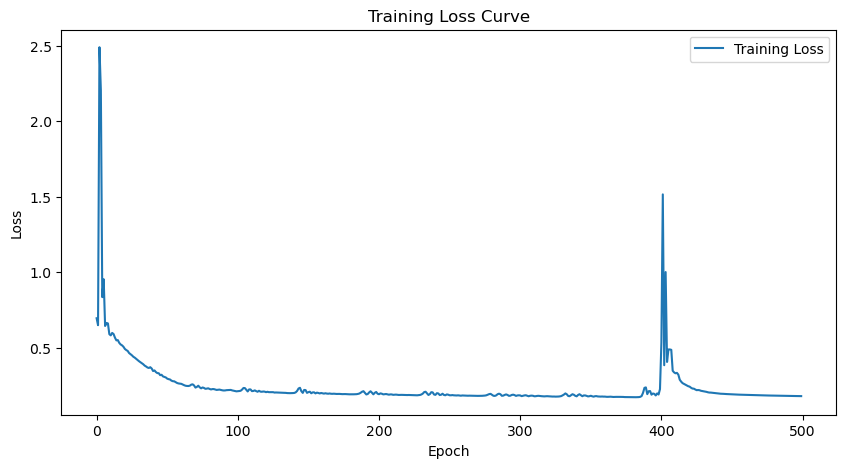

Final Model Accuracy: 72.29%


In [10]:
input_dim = X_train.shape[1]
hidden_dim = 256 
print(f"Training MLP model with input_dim={input_dim} and hidden_dim={hidden_dim}")

custom_mlp, losses, best_accuracy = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)

In [11]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to '{filepath}'.")

save_checkpoint(custom_mlp, torch.optim.Adam(custom_mlp.parameters()), len(losses), losses[-1], checkpoint_file)

Checkpoint saved to '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_last_layer_test.pth'.


In [12]:
y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
print(classification_report(y_test, y_pred_final, target_names=["infringement", "non_infringement"]))

                  precision    recall  f1-score   support

    infringement       0.83      0.54      0.66       283
non_infringement       0.67      0.89      0.77       298

        accuracy                           0.72       581
       macro avg       0.75      0.72      0.71       581
    weighted avg       0.75      0.72      0.71       581



/tmp/ipykernel_1883368/2137335780.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
